In [1]:
import sys
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy

# suppress warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append('../')
from envir import config

In [3]:
# read in files
files = ['KDIX2016night.csv', 'KDIX2017night.csv',
         'KDIX2018night.csv', 'KDIX2019night.csv']
kdix = pd.DataFrame()
for f in files:
    temp = pd.read_csv(config.dataFol+'clean_nexrad/'+f)
    kdix = kdix.append(temp)

In [4]:
kdix['year'] = pd.DatetimeIndex(kdix['datetime']).year
kdix['month'] = pd.DatetimeIndex(kdix['datetime']).month
kdix['day'] = pd.DatetimeIndex(kdix['datetime']).day
kdix['hour'] = pd.DatetimeIndex(kdix['datetime']).hour
kdix['minute'] = pd.DatetimeIndex(kdix['datetime']).minute
kdix['date'] = pd.to_datetime(kdix.year*10000+kdix.month*100+kdix.day,format='%Y%m%d')
kdix['datetime'] = pd.to_datetime(kdix.datetime)
kdix.set_index(kdix.datetime, inplace=True)

In [5]:
kdix.head(2)

,datetime,mtr,vid,vir,rtr,mt,rt,ff,dd,u,...,airspeed,heading,airspeed_u,airspeed_v,year,month,day,hour,minute,date
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:03:25,2016-01-01 00:03:25,6.632379,0.315422,3.46964,72.956165,0.548092,6.029016,5.840837,128.025349,4.561821,...,3.288463,217.405840,-2.980551,-1.144839,2016,1,1,0,3,2016-01-01
2016-01-01 00:13:20,2016-01-01 00:13:20,3.534325,0.168901,1.85791,38.877571,1.132729,12.460015,5.812620,129.504868,4.440804,...,3.013463,234.108694,-2.546053,-1.372937,2016,1,1,0,13,2016-01-01


In [6]:
kdix.describe()

,mtr,vid,vir,rtr,mt,rt,ff,dd,u,v,height,airspeed,heading,airspeed_u,airspeed_v,year,month,day,hour,minute
count,136156.000000,136156.000000,136156.000000,136156.000000,1.361560e+05,1.361560e+05,136156.000000,136156.000000,136156.000000,136156.000000,136156.000000,136156.000000,136156.000000,136156.000000,136156.000000,136156.000000,136156.000000,136156.000000,136156.000000,136156.000000
mean,408.484323,10.596242,116.558663,4493.327553,9.013325e+05,9.914658e+06,8.993475,98.864431,2.539815,0.344020,517.052489,4.821409,99.786381,-0.772542,0.006481,2017.405733,6.221525,15.687043,6.364384,29.497459
std,1460.346757,33.740864,371.149503,16063.814325,8.719439e+05,9.591383e+06,4.730152,86.250064,6.253544,6.993118,284.114290,3.658437,85.934752,3.722290,4.216202,1.055303,3.518845,8.757708,5.675009,17.307695
min,0.000000,0.004385,0.048230,0.000000,2.962784e-01,3.259063e+00,0.000000,-89.997213,-74.170111,-77.275624,120.256852,0.000000,-87.026659,-80.282278,-73.777616,2016.000000,1.000000,1.000000,0.000000,0.000000
25%,8.023363,0.272041,2.992455,88.256997,7.879515e+04,8.667466e+05,5.952675,37.410874,-1.667916,-4.369421,305.454913,2.730373,27.883522,-2.495440,-2.220145,2016.000000,3.000000,8.000000,2.000000,14.000000
50%,37.937509,1.384292,15.227210,417.312596,8.016457e+05,8.818103e+06,8.236134,89.129744,2.892474,0.055042,450.086598,3.952702,98.328470,-0.620360,-0.090873,2017.000000,6.000000,16.000000,5.000000,30.000000
75%,153.553283,5.588829,61.477118,1689.086115,1.333774e+06,1.467151e+07,10.908737,169.270104,6.756510,4.935494,654.124759,5.993449,175.622858,1.147980,1.900687,2018.000000,9.000000,23.000000,8.000000,44.000000
max,30555.700057,588.568975,6474.258730,336112.700632,2.812864e+06,3.094151e+07,85.607595,269.976995,75.864589,83.083329,2617.119812,87.609759,268.459096,67.424280,85.754852,2019.000000,12.000000,31.000000,23.000000,59.000000


In [7]:
# scans per year
kdix.groupby(['year']).count()['mtr']

year
2016    34438
2017    37000
2018    39755
2019    24963
Name: mtr, dtype: int64

Text(0, 0.5, 'mtr')

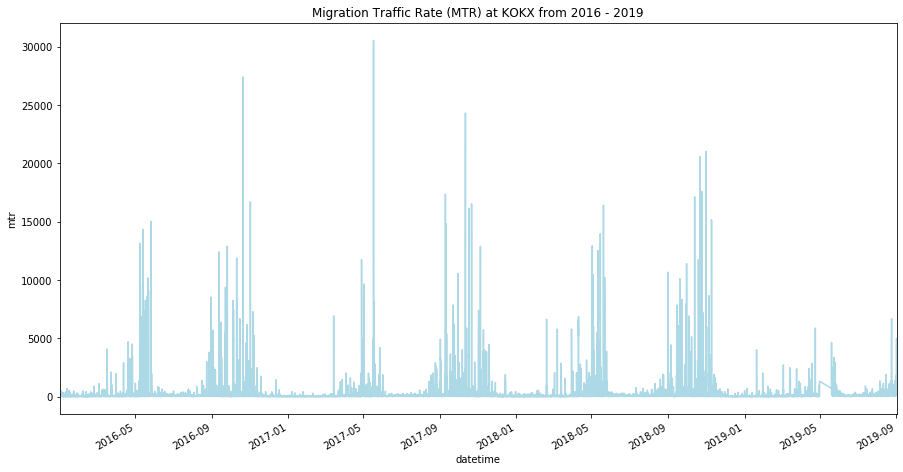

In [8]:
kdix['mtr'].plot(color='lightblue', figsize=(15, 8))
plt.title('Migration Traffic Rate (MTR) at KOKX from 2016 - 2019', fontsize=12)
plt.ylabel('mtr')

In [9]:
kdix.groupby(['year', 'month', 'day']).mean()['mtr']

year  month  day
2016  1      1         8.434057
             2        16.650105
             3        20.319159
             4        15.920958
             5        48.067206
                       ...     
2019  8      28       66.421783
             29      466.414637
             30      824.368664
             31      735.565301
      9      1      2880.416823
Name: mtr, Length: 1316, dtype: float64

Text(0, 0.5, 'mtr')

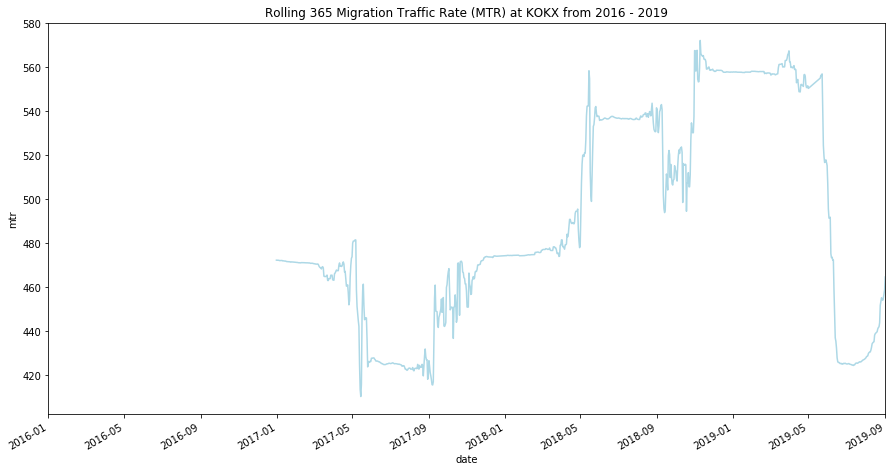

In [10]:
kdix.groupby(['date']).mean()['mtr'].rolling(window = 365).mean().plot(color='lightblue', figsize=(15, 8))
plt.title('Rolling 365 Migration Traffic Rate (MTR) at KOKX from 2016 - 2019', fontsize=12)
plt.ylabel('mtr')

In [11]:
kdix_by_day = kdix.groupby(['date']).mean()
pd.to_datetime(kdix_by_day.index).year


Int64Index([2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016,
            ...
            2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
           dtype='int64', name='date', length=1316)

In [12]:
kdix_by_day.head()


,mtr,vid,vir,rtr,mt,rt,ff,dd,u,v,height,airspeed,heading,airspeed_u,airspeed_v,year,month,day,hour,minute
date,,,,,,,,,,,,,,,,,,,,
2016-01-01,8.434057,0.368538,4.053915,92.774628,218.091806,2399.009871,6.637819,125.670153,5.025085,-3.679210,361.031921,2.974672,81.669598,-2.080584,-0.122312,2016.0,1.0,1.0,8.500000,28.644444
2016-01-02,16.650105,0.529629,5.825923,183.151154,1514.898734,16663.886072,8.619442,120.380576,5.083979,-3.975881,377.330184,5.638029,73.116394,-3.394312,-0.645059,2016.0,1.0,2.0,8.318182,32.181818
2016-01-03,20.319159,0.676296,7.439260,223.510753,3940.435141,43344.786547,10.383250,95.551673,4.726758,1.210809,491.939445,10.116346,143.117117,-3.490688,0.248879,2016.0,1.0,3.0,8.318182,28.147727
2016-01-04,15.920958,0.506358,5.569943,175.130541,6251.205496,68763.260452,9.559646,155.599303,3.351110,-8.224136,329.210087,4.596099,128.000973,-1.248121,-1.936807,2016.0,1.0,4.0,8.258427,31.247191
2016-01-05,48.067206,0.957272,10.529989,528.739263,7659.762751,84257.390259,15.053788,169.765179,-1.477601,-11.877761,633.044451,8.592263,144.254441,-0.732630,-3.976701,2016.0,1.0,5.0,8.318182,30.318182


In [13]:
kdix_by_month = kdix.groupby(['year', 'month']).mean()
kdix_by_month.reset_index().pivot(index='month', columns='year', values='mtr')


year,2016,2017,2018,2019
month,,,,
1,25.535640,12.060205,12.084060,17.101631
2,21.065958,12.123520,44.861262,20.830116
3,179.231058,82.460828,123.013948,173.149268
4,300.257496,428.716582,428.839044,252.659966
5,1310.043463,823.853750,1756.959932,736.423472
6,98.445665,101.773200,80.022253,70.275859
7,99.406874,62.907683,59.975178,94.499686
8,325.015548,296.315514,394.810534,415.182908
9,835.317241,1386.526782,1109.992233,2880.416823


In [14]:
import seaborn as sns
kdix_by_month.reset_index().head()


,year,month,mtr,vid,vir,rtr,mt,rt,ff,dd,u,v,height,airspeed,heading,airspeed_u,airspeed_v,day,hour,minute
0,2016,1,25.535640,0.701338,7.714715,280.892041,23025.719773,2.532829e+05,12.311124,113.724808,3.302719,-2.449258,420.834490,7.951197,107.152914,-0.139437,-0.801887,16.130530,8.141512,29.294321
1,2016,2,21.065958,0.529048,5.819528,231.725537,58987.617354,6.488638e+05,10.442364,91.077104,3.140811,1.625606,518.717817,4.780366,85.129252,-0.478516,0.231146,15.692877,7.403385,29.758815
2,2016,3,179.231058,3.240124,35.641361,1971.541637,112453.136299,1.236984e+06,10.867907,80.074381,4.271293,3.185796,501.578534,5.821397,66.155844,0.634894,2.956164,15.873255,6.488006,29.680988
3,2016,4,300.257496,5.606136,61.667494,3302.832458,204336.058593,2.247697e+06,10.927293,99.809639,4.613455,3.289070,517.130978,6.051984,63.409360,1.691515,2.835666,15.356618,5.421324,29.683824
4,2016,5,1310.043463,32.744421,360.188635,14410.478093,536983.169031,5.906815e+06,7.754751,71.436851,2.973376,3.946302,538.945697,5.901413,51.527041,1.626673,3.913829,15.598854,4.476003,29.390043


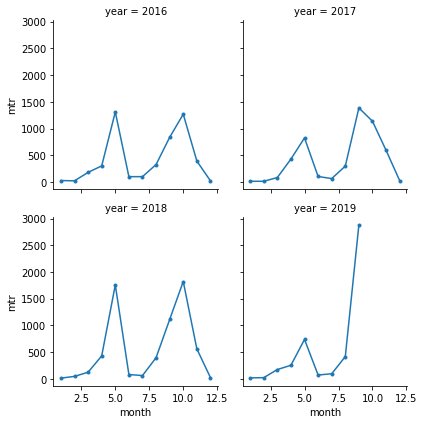

In [15]:
# annual patterns of mtr
g = sns.FacetGrid(kdix_by_month.reset_index(), col="year", col_wrap=2, height=3)
g = g.map(plt.plot, "month", "mtr", marker=".")

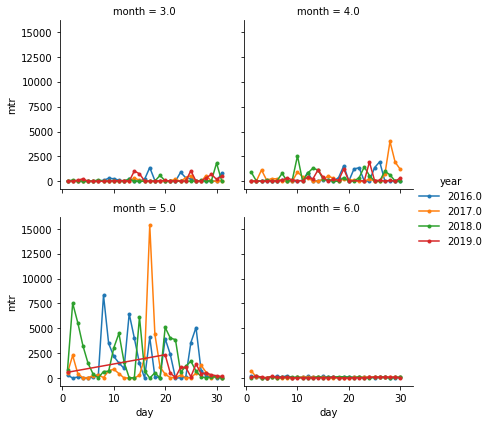

In [16]:
# annual patterns of mtr in March - June
g = sns.FacetGrid(kdix_by_day[(kdix_by_day['month']>=3) & (kdix_by_day['month']<=6)], hue="year",
                  col="month", col_wrap=2, height=3)
g = (g.map(plt.plot, "day", "mtr", marker=".").add_legend())

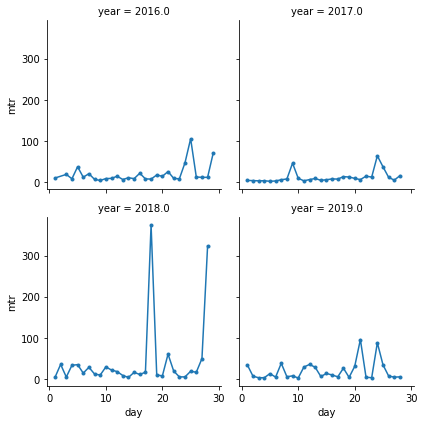

In [17]:
# annual patterns of mtr in March
g = sns.FacetGrid(kdix_by_day[kdix_by_day['month']==2], col="year", col_wrap=2, height=3)
g = g.map(plt.plot, "day", "mtr", marker=".")

##### Potential Peaks
- 2/25/2016
- 2/9/2017
- 2/18/2018, 2/28/2018
- 2/21/2019, 2/24/2019

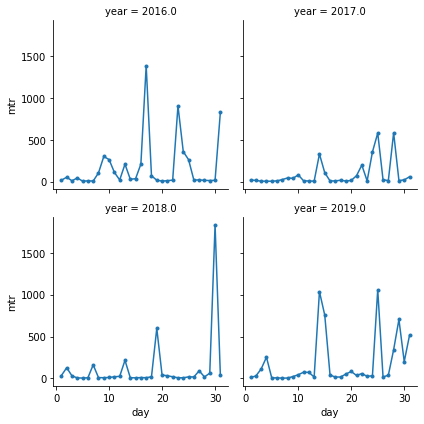

In [18]:
# annual patterns of mtr in March
g = sns.FacetGrid(kdix_by_day[kdix_by_day['month']==3], col="year", col_wrap=2, height=3)
g = g.map(plt.plot, "day", "mtr", marker=".")

##### Potential Peaks
- 3/17/2016, 3/23/2016
- 3/14/2017, 3/25/2017, 3/28/2017
- 3/2/2018, 3/6/2018, 3/13/2018, 3/19/2018, 3/30/2018
- 3/4/2019, 3/15/2019, 3/25/2019,3/29/2019

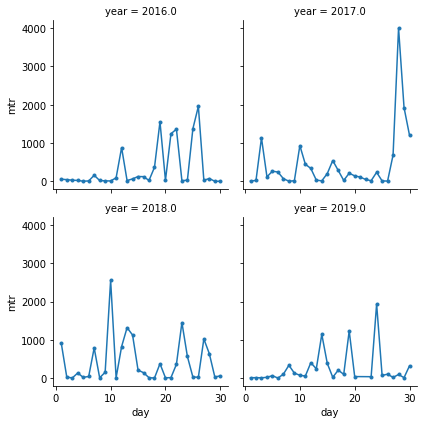

In [19]:
# annual patterns of mtr in April
g = sns.FacetGrid(kdix_by_day[kdix_by_day['month']==4], col="year", col_wrap=2, height=3)
g = g.map(plt.plot, "day", "mtr", marker=".")

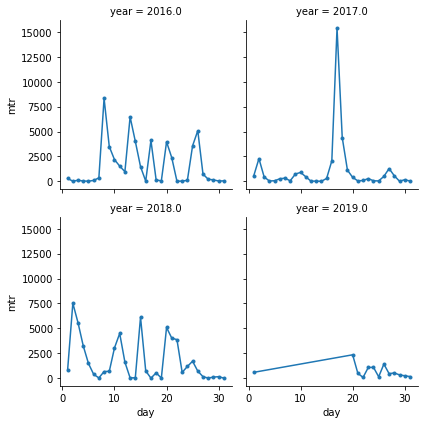

In [20]:
# annual patterns of mtr in May
g = sns.FacetGrid(kdix_by_day[kdix_by_day['month']==5], col="year", col_wrap=2, height=3)
g = g.map(plt.plot, "day", "mtr", marker=".")

In [21]:
dow = kdix_by_day.index.to_series()

In [22]:
kdix_by_day['day_of_week'] = dow.dt.dayofweek

In [23]:
kdix_by_day.head()

,mtr,vid,vir,rtr,mt,rt,ff,dd,u,v,...,airspeed,heading,airspeed_u,airspeed_v,year,month,day,hour,minute,day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,8.434057,0.368538,4.053915,92.774628,218.091806,2399.009871,6.637819,125.670153,5.025085,-3.679210,...,2.974672,81.669598,-2.080584,-0.122312,2016.0,1.0,1.0,8.500000,28.644444,4
2016-01-02,16.650105,0.529629,5.825923,183.151154,1514.898734,16663.886072,8.619442,120.380576,5.083979,-3.975881,...,5.638029,73.116394,-3.394312,-0.645059,2016.0,1.0,2.0,8.318182,32.181818,5
2016-01-03,20.319159,0.676296,7.439260,223.510753,3940.435141,43344.786547,10.383250,95.551673,4.726758,1.210809,...,10.116346,143.117117,-3.490688,0.248879,2016.0,1.0,3.0,8.318182,28.147727,6
2016-01-04,15.920958,0.506358,5.569943,175.130541,6251.205496,68763.260452,9.559646,155.599303,3.351110,-8.224136,...,4.596099,128.000973,-1.248121,-1.936807,2016.0,1.0,4.0,8.258427,31.247191,0
2016-01-05,48.067206,0.957272,10.529989,528.739263,7659.762751,84257.390259,15.053788,169.765179,-1.477601,-11.877761,...,8.592263,144.254441,-0.732630,-3.976701,2016.0,1.0,5.0,8.318182,30.318182,1


### Deeper Look at By Hour By Height

#### Peaks in the month of May
Since the above line plots seem to demonstrate peaks in May for each year. Let's sample a couple of dates to look at both the mtr and the height metric for exploration.
##### Dates to Examine:
* May 26, 2016
* May 17, 2017
* May 22, 2018
* May 20, 2019

In [24]:
may_peaks = ['2016-05-26', '2017-05-17', '2018-05-22', '2019-05-20']
kdix_by_day[kdix_by_day.index.isin(may_peaks)]

,mtr,vid,vir,rtr,mt,rt,ff,dd,u,v,...,airspeed,heading,airspeed_u,airspeed_v,year,month,day,hour,minute,day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2016-05-26,5083.673986,90.285105,993.136154,55920.413844,763657.852892,8.400236e+06,14.352238,50.340649,10.778282,9.237255,...,13.031955,45.155726,8.843882,8.980197,2016.0,5.0,26.0,4.446429,28.125000,3
2017-05-17,15382.707726,243.067588,2673.743466,169209.784991,401428.384309,4.415712e+06,16.672295,46.000600,11.897603,11.547714,...,11.748804,31.533419,6.169279,9.903481,2017.0,5.0,17.0,4.344828,29.637931,2
2018-05-22,3869.561832,102.023445,1122.257891,42565.180147,822642.954881,9.049073e+06,8.690746,29.446694,4.762351,6.892866,...,7.859164,20.296930,2.946126,6.903642,2018.0,5.0,22.0,4.970588,29.323529,1
2019-05-20,2350.128147,28.112833,309.241163,25851.409613,707908.608606,7.786995e+06,22.261807,43.291585,15.058246,15.965714,...,6.499385,49.612976,3.526113,4.449494,2019.0,5.0,20.0,4.944444,29.129630,0


In [25]:
kdix[kdix.date.isin(may_peaks)].groupby('date').count()

,datetime,mtr,vid,vir,rtr,mt,rt,ff,dd,u,...,height,airspeed,heading,airspeed_u,airspeed_v,year,month,day,hour,minute
date,,,,,,,,,,,,,,,,,,,,,
2016-05-26,56,56,56,56,56,56,56,56,56,56,...,56,56,56,56,56,56,56,56,56,56
2017-05-17,58,58,58,58,58,58,58,58,58,58,...,58,58,58,58,58,58,58,58,58,58
2018-05-22,68,68,68,68,68,68,68,68,68,68,...,68,68,68,68,68,68,68,68,68,68
2019-05-20,108,108,108,108,108,108,108,108,108,108,...,108,108,108,108,108,108,108,108,108,108


In [26]:
kdix.index.to_series().diff().mean()

Timedelta('0 days 00:14:09.963872')

2016-05-26
Average time in minutes between scans
0 days 00:09:54
2017-05-17
Average time in minutes between scans
0 days 00:09:54
2018-05-22
Average time in minutes between scans
0 days 00:09:48
2019-05-20
Average time in minutes between scans
0 days 00:04:41


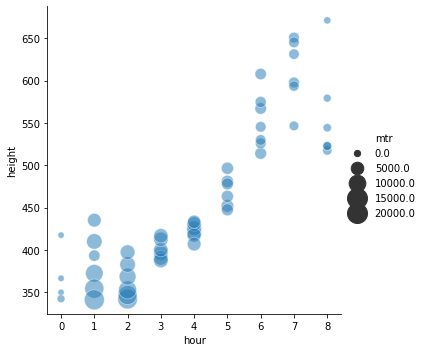

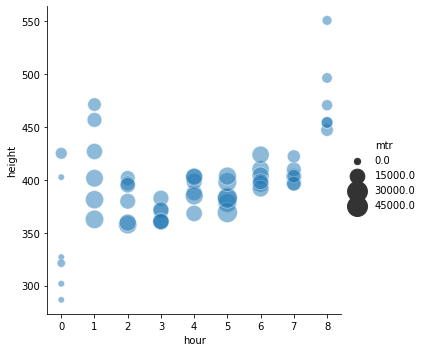

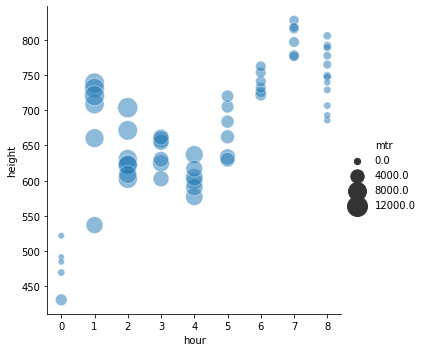

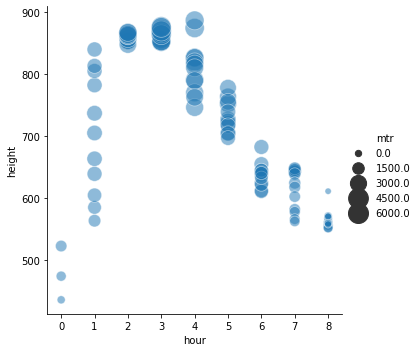

In [27]:
for i in may_peaks:
    print(i)
    print("Average time in minutes between scans")
    print(kdix[kdix.date.isin([i])].index.to_series().diff().median())
    sns.relplot(x='hour', y="height", size="mtr",
                sizes=(40, 400), alpha=.5, palette="muted",
                height=5, data=kdix[(kdix.date.isin([i])) & (kdix.hour <=8)])

2016-05-26
Average time in minutes between scans
0 days 00:09:54
2017-05-17
Average time in minutes between scans
0 days 00:09:54
2018-05-22
Average time in minutes between scans
0 days 00:09:48
2019-05-20
Average time in minutes between scans
0 days 00:04:41


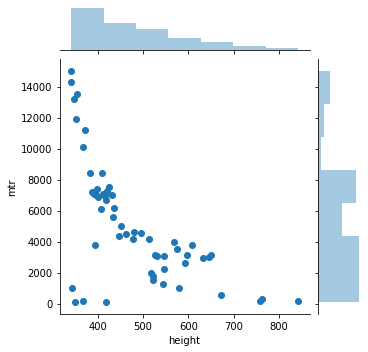

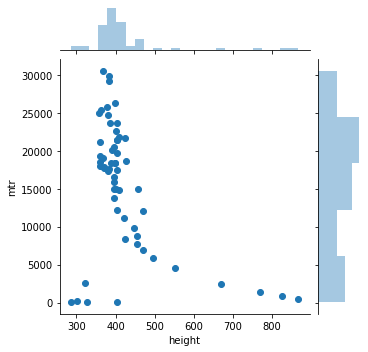

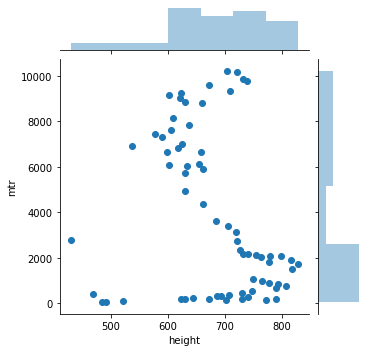

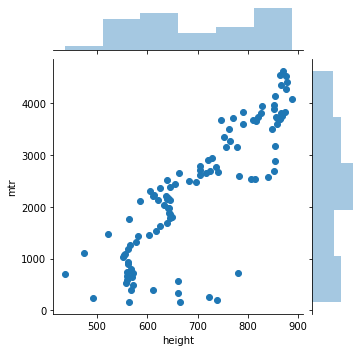

In [28]:
for i in may_peaks:
    print(i)
    print("Average time in minutes between scans")
    print(kdix[kdix.date.isin([i])].index.to_series().diff().median())
    sns.jointplot(x=kdix[(kdix.date.isin([i]))].height,
                  y=kdix[(kdix.date.isin([i]))].mtr,
                  kind='scatter', height=5 )

In [29]:
for i in may_peaks:
    print(i)
    print("Average time in minutes between scans")
    print(kdix[kdix.date.isin([i])].index.to_series().diff().median())
    print(kdix[kdix.date.isin([i])].index.to_series().diff().mean())
    print(kdix[kdix.date.isin([i])].index.to_series().diff().mode())


2016-05-26
Average time in minutes between scans
0 days 00:09:54
0 days 00:09:56.236363
0   00:09:54
dtype: timedelta64[ns]
2017-05-17
Average time in minutes between scans
0 days 00:09:54
0 days 00:09:58.456140
0   00:09:54
dtype: timedelta64[ns]
2018-05-22
Average time in minutes between scans
0 days 00:09:48
0 days 00:08:27.582089
0   00:09:49
dtype: timedelta64[ns]
2019-05-20
Average time in minutes between scans
0 days 00:04:41
0 days 00:04:56.616822
0   00:04:41
dtype: timedelta64[ns]


In [30]:
for i in range(2016, 2020) :
    print(i)
    print("Average time in minutes between scans")
    print(kdix[kdix.date.isin([i])].index.to_series().diff().median())
    print(kdix[kdix.date.isin([i])].index.to_series().diff().mean())
    print(kdix[kdix.date.isin([i])].index.to_series().diff().mode())


2016
Average time in minutes between scans
NaT
NaT
Series([], dtype: timedelta64[ns])
2017
Average time in minutes between scans
NaT
NaT
Series([], dtype: timedelta64[ns])
2018
Average time in minutes between scans
NaT
NaT
Series([], dtype: timedelta64[ns])
2019
Average time in minutes between scans
NaT
NaT
Series([], dtype: timedelta64[ns])


In [31]:
kdix_by_year_standard = kdix[['year', 'mtr', 'height']].groupby('year').transform(lambda x: (x - x.mean()) / x.std())
kdix_by_year_standard.rename(columns = {'mtr':'mtr_standardized', 'height': 'height_standardized'}, inplace=True)

In [32]:
kdix = pd.concat([kdix, kdix_by_year_standard], axis=1)

2016
Average time in minutes between scans
0 days 00:09:52
0 days 00:15:18.032087
0   00:09:55
dtype: timedelta64[ns]
2017
Average time in minutes between scans
0 days 00:05:49
0 days 00:14:12.131895
0   00:09:54
dtype: timedelta64[ns]
2018
Average time in minutes between scans
0 days 00:05:49
0 days 00:13:13.071716
0   00:07:08
dtype: timedelta64[ns]
2019
Average time in minutes between scans
0 days 00:06:10
0 days 00:14:02.578158
0   00:07:08
dtype: timedelta64[ns]


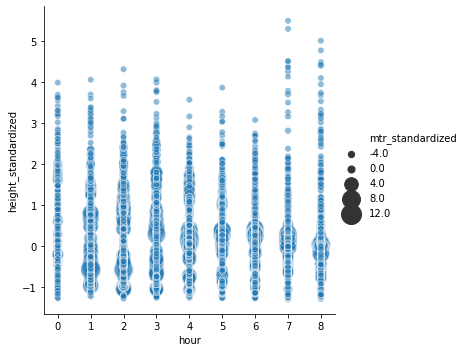

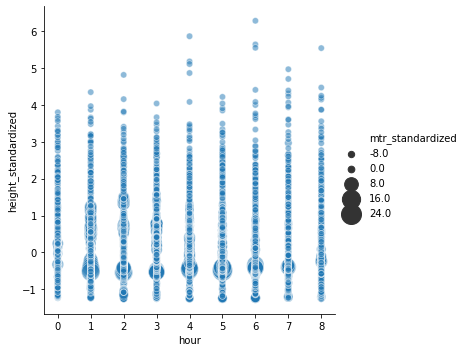

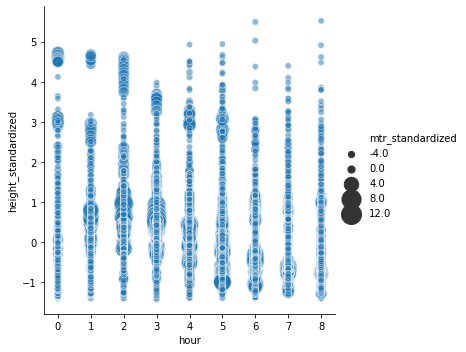

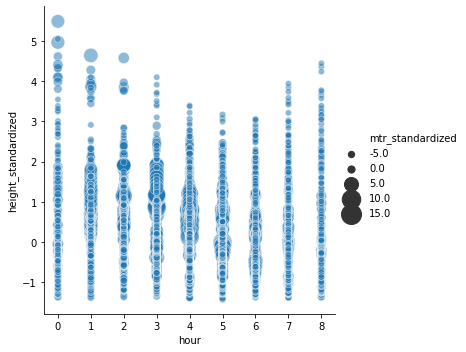

In [33]:
for i in range(2016, 2020):
    print(i)
    print("Average time in minutes between scans")
    print(kdix[kdix.year==i].index.to_series().diff().median())
    print(kdix[kdix.year==i].index.to_series().diff().mean())
    print(kdix[kdix.year==i].index.to_series().diff().mode())
    sns.relplot(x='hour', y="height_standardized", size="mtr_standardized",
                sizes=(40, 400), alpha=.5, palette="muted",
                height=5, data=kdix[(kdix.year==i) & (kdix.hour <=8) & (kdix.month.isin([3, 4, 5, 6]))])